## Module 2 : Finding Neutral Atom Qubit Gates
### Exercise 2-3 : CZ-gate fidelity with two Atom Qubits
Problem Unsolved : 
- CZ gate matrix form is diag(1,1,1,-1) or diag(1,-1,-1,-1). This is important for the fidelity of superposition state case.
- whether the fidelity is achievable ? Or the optimization is to provide a guide for experiments ? And do we need to test the stability of the fidelity ?
- How to understand the relation between parameters' changes and fidelity changes ?? ( numerically and physically )

In [1]:
%reset
%reload_ext autoreload
%autoreload 2

# Import ALL configuration variables from config file
from Default_TQCONFIG_for_CZ_GATE import *
from myPkg.optimization_utils import *
from scipy.optimize import minimize

## Exercise : Find Optimal Parameters $(\Omega_{r}, \tau, \Delta_r, T)$ for various values of $B/2\pi$
- $T, \tau, \Omega_r, \Delta_r, B$ are experimentally tunable parameters, while atomic parameters $ \Omega_{01}, \delta_1, \gamma_r, b_{0r}, b_{1r}, b_{dr} $ are harder to tune ??
- Here I use the single process rather than the multiprocess, since I don't know how to do  multiprocess in notebook

In [2]:
scale_B_list = [0, 50, 100, 200, 300, 400, 500, 600]  # [MHz]
Rydberg_B_list = [scale_B * 2 * np.pi for scale_B in scale_B_list]

#### Create a new directory

In [3]:
# Create save directory
task_name = 'CZ_gate_pulse_optimization'
save_dir = create_save_directory(task_name, base_dir='save_data', subdir='optimization_results')

💾 Save directory created: save_data\optimization_results\20260108_171700_CZ_gate_pulse_optimization


#### Preparation

In [4]:
# Define initial parameters
initial_params = {
  'T_gate': 0.4548,
  'tau_ratio': 0.1576,
  'amp_Omega_r': 62.83341,
  'amp_Delta_r': 110.7900
}

# Define bounds
bounds = {
  'T_gate': (0.25, 2.25),
  'tau_ratio': (0.05, 0.75),
  'amp_Omega_r': (10*2*np.pi, 20*2*np.pi),
  'amp_Delta_r': (10*2*np.pi, 30*2*np.pi)
}

# Convert to arrays
param_names = ['T_gate', 'tau_ratio', 'amp_Omega_r', 'amp_Delta_r']
x0 = np.array([initial_params[name] for name in param_names])
param_bounds = [bounds[name] for name in param_names]

# Set default options
options = {'maxiter': 300, 'disp': True, 'fatol': 1e-6, 'xatol': 1e-4}

In [5]:
psi0_list = make_initial_list_for_gate_fidelity(num_qubits = 2, dim_atom = 4)
qs0_list = make_initial_list_for_gate_fidelity(num_qubits = 2, dim_atom = 2)

#### Run the Optimization

In [6]:
import time

# ============================================================================
# Print start message
# ============================================================================
print(f"\n{'='*70}")
print(f"🚀 Starting Serial Optimization")
print(f"   Total B values: {len(Rydberg_B_list)}")
print(f"{'='*70}\n")

# ============================================================================
# Start computation
# ============================================================================
total_start = time.time()
results = []
for idx, Rydberg_B in enumerate(Rydberg_B_list):
    scale_B = Rydberg_B / (2 * np.pi)
    
    print(f"🚀 [{idx+1}/{len(Rydberg_B_list)}] Starting B = {scale_B:.0f} MHz")
    start_time = time.time()
    
    # Create objective function
    coupling_params = {'Rydberg_B': Rydberg_B}
    objective_func = create_TQ_pulse_optimizer(
        pulse_type='ARP',
        pulse_functions={'Omega_r': APR_pulse_Omega_r, 'Delta_r': APR_pulse_Delta_r},
        atom0_base_params=atom0_ham_params,
        atom1_base_params=atom1_ham_params,
        lindblad_params=lindblad_params,
        coupling_params=coupling_params,
        target_gate=target_gate,
        qs0_list=qs0_list,
        psi0_list=psi0_list,
        comp_indices=comp_indices,
        expect_list=None,
        fidelity_type='mixed',
        num_time_points=300
    )
    
    # Run optimization
    monitor = OptimizationMonitor(param_names, objective_func, verbose=False)
    result = minimize(objective_func, x0, method='Nelder-Mead',
                      bounds=param_bounds, options=options, callback=monitor)
    
    # Get best result
    best = monitor.get_best_result()
    best['Rydberg_B_MHz'] = scale_B
    results.append(best)
    
    # Save individual result
    save_path = save_dir / f'monitor_B{int(scale_B)}MHz.pkl'
    monitor.save(save_path)
    
    elapsed = time.time() - start_time
    print(f"✅ [{idx+1}/{len(Rydberg_B_list)}] Completed B = {scale_B:.0f} MHz, "
          f"F = {best['fidelity']:.6f}, Time = {elapsed:.1f}s\n")

total_time = time.time() - total_start

# ============================================================================
# Print summary
# ============================================================================
print(f"{'='*70}")
print(f"✅ Serial Optimization Complete!")
print(f"   Total time: {total_time/60:.1f} minutes")
print(f"   Average per B: {total_time/len(results):.1f} seconds")
print(f"   Successful: {len(results)}/{len(Rydberg_B_list)}")
print(f"{'='*70}\n")


🚀 Starting Serial Optimization
   Total B values: 8

🚀 [1/8] Starting B = 0 MHz


d:\anaconda3\envs\my_qiskit\Lib\site-packages\qutip\core\data\expm.py:139: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  return Dense(scipy.linalg.sqrtm(matrix.as_ndarray()))


Optimization terminated successfully.
         Current function value: 0.350692
         Iterations: 75
         Function evaluations: 163
✅ Saved optimization monitor to: save_data\optimization_results\20260108_171700_CZ_gate_pulse_optimization\monitor_B0MHz.pkl
✅ [1/8] Completed B = 0 MHz, F = 0.649308, Time = 15.8s

🚀 [2/8] Starting B = 50 MHz
Optimization terminated successfully.
         Current function value: 0.018121
         Iterations: 151
         Function evaluations: 289
✅ Saved optimization monitor to: save_data\optimization_results\20260108_171700_CZ_gate_pulse_optimization\monitor_B50MHz.pkl
✅ [2/8] Completed B = 50 MHz, F = 0.981879, Time = 43.7s

🚀 [3/8] Starting B = 100 MHz
Optimization terminated successfully.
         Current function value: 0.018290
         Iterations: 151
         Function evaluations: 291
✅ Saved optimization monitor to: save_data\optimization_results\20260108_171700_CZ_gate_pulse_optimization\monitor_B100MHz.pkl
✅ [3/8] Completed B = 100 MHz, 

In [7]:
summary_data = [{
    'Rydberg_B_MHz': r['Rydberg_B_MHz'],
    'fidelity': r['fidelity'],
    **r['params']
} for r in results]

df = save_optimization_summary(summary_data, save_dir, verbose=True)

💾 Saved summary to: save_data\optimization_results\20260108_171700_CZ_gate_pulse_optimization\summary.csv
   Total results: 8

 Rydberg_B_MHz  fidelity   T_gate  tau_ratio  amp_Omega_r  amp_Delta_r
           0.0  0.649308 0.380493   0.189758    62.832249   123.167711
          50.0  0.981879 0.412318   0.118281    62.836520   147.598700
         100.0  0.981710 0.456412   0.278522    62.831853   110.921622
         200.0  0.995240 0.459129   0.285017    62.831853   109.651348
         300.0  0.997724 0.473072   0.256019    62.831853   106.671636
         400.0  0.997402 0.739328   0.144553    72.233344   110.323098
         500.0  0.998585 0.731010   0.166275    62.832696    83.191948
         600.0  0.998418 0.862205   0.175482    62.854475    80.335944


(<Figure size 1200x800 with 4 Axes>,
 array([[<Axes: title={'center': 'Fidelity Convergence'}, xlabel='Iteration', ylabel='Fidelity'>,
         <Axes: title={'center': 'Infidelity Convergence'}, xlabel='Iteration', ylabel='Infidelity (log scale)'>],
        [<Axes: title={'center': 'Parameter Evolution'}, xlabel='Iteration', ylabel='Parameter Value'>,
         <Axes: title={'center': 'Normalized Parameter Evolution'}, xlabel='Iteration', ylabel='Normalized Change'>]],
       dtype=object))

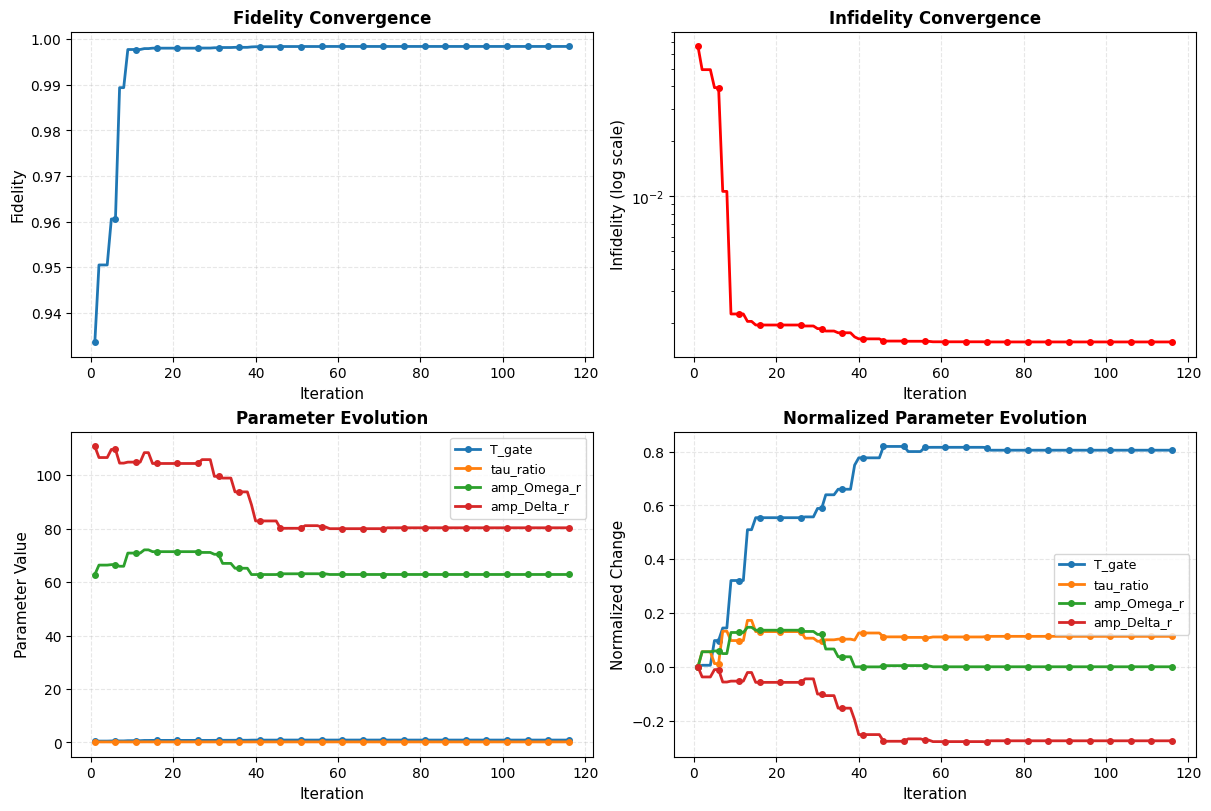

In [8]:
# monitor = OptimizationMonitor.load(filepath=save_dir / 'monitor_B300MHz.pkl', objective_func=objective_func)
monitor.plot_convergence()

### 2. Plot Fidelity vs Rydberg Blockade Strength

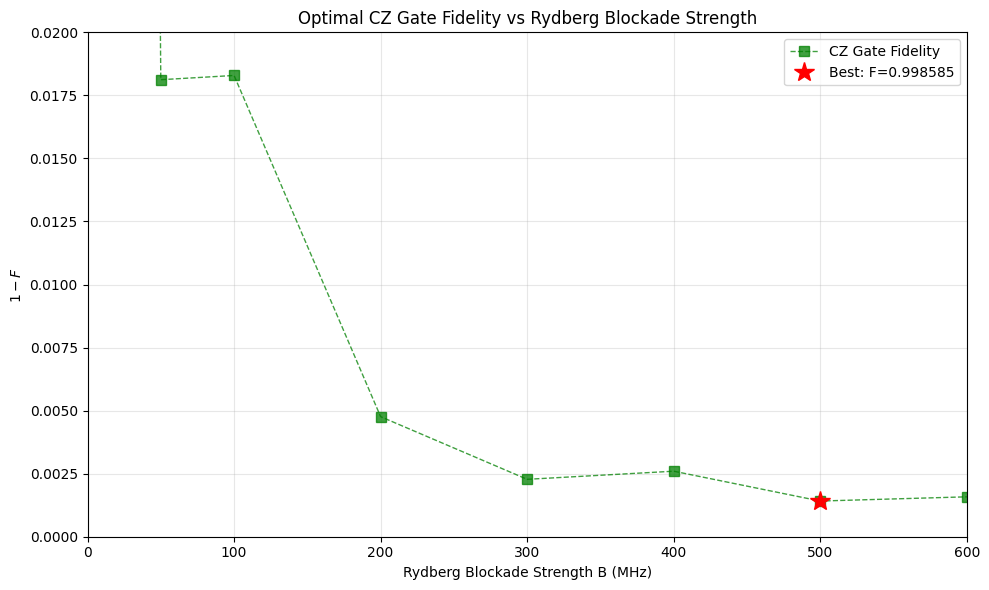


🏆 Best Fidelity Result:
  B = 500 MHz
  Fidelity = 0.998585
  Infidelity = 1.41e-03


In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot fidelity vs B using plotting_helpers function
plot_fidelity_vs_parameter(
    ax=ax,
    param_list=df['Rydberg_B_MHz'].values,
    fidelity_list=[df['fidelity'].values],
    legend_list=['CZ Gate Fidelity'],
    title='Optimal CZ Gate Fidelity vs Rydberg Blockade Strength',
    xlabel='Rydberg Blockade Strength B (MHz)',
    ylabel='Fidelity',
    use_infidelity=True,
    log_scale=False,
    ylim=[0, 0.02],
    grid_alpha=0.3,
    show_legend=True
)

# Mark the best fidelity point
best_idx = df['fidelity'].idxmax()
ax.plot(df.loc[best_idx, 'Rydberg_B_MHz'], 1 - df.loc[best_idx, 'fidelity'], 
        'r*', markersize=15, label=f"Best: F={df.loc[best_idx, 'fidelity']:.6f}")
ax.legend()

plt.tight_layout()
plt.show()

# Print best result
print(f"\n🏆 Best Fidelity Result:")
print(f"  B = {df.loc[best_idx, 'Rydberg_B_MHz']:.0f} MHz")
print(f"  Fidelity = {df.loc[best_idx, 'fidelity']:.6f}")
print(f"  Infidelity = {1 - df.loc[best_idx, 'fidelity']:.2e}")

### 3. Plot Optimized Parameters vs B

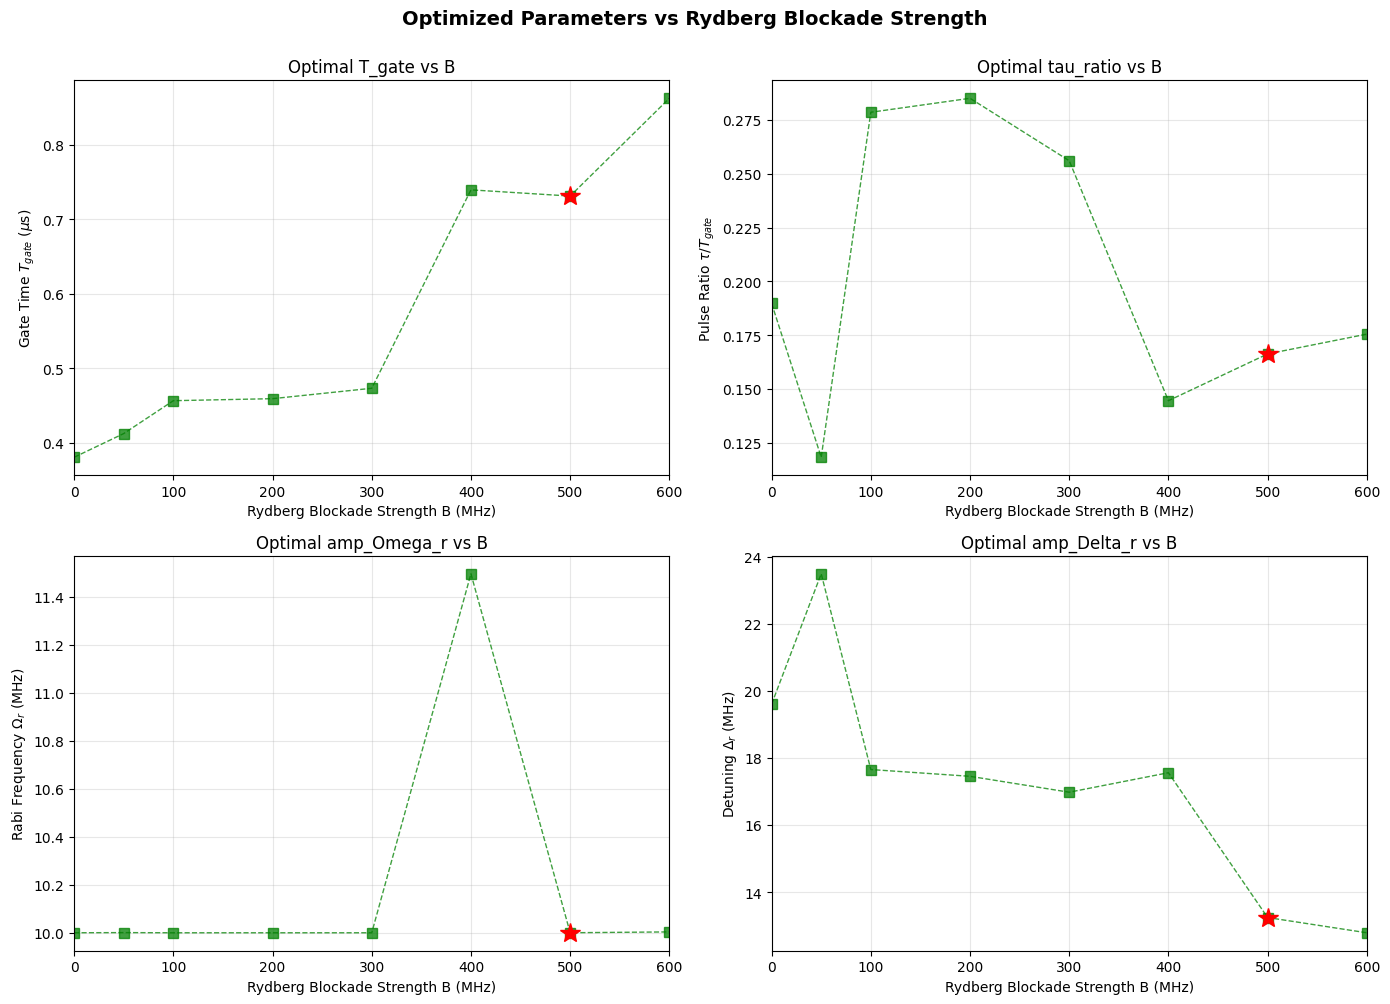

In [10]:
# from plotting_helpers import plot_parameter_vs_parameter

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Parameter information: (column_name, ylabel, need_conversion_to_MHz)
param_info = [
    ('T_gate', r'Gate Time $T_{gate}$ ($\mu$s)', False, axes[0, 0]),
    ('tau_ratio', r'Pulse Ratio $\tau / T_{gate}$', False, axes[0, 1]),
    ('amp_Omega_r', r'Rabi Frequency $\Omega_r$ (MHz)', True, axes[1, 0]),
    ('amp_Delta_r', r'Detuning $\Delta_r$ (MHz)', True, axes[1, 1])
]

for param_name, ylabel, convert_to_MHz, ax in param_info:
    # Convert to appropriate units
    if convert_to_MHz:
        # Convert from rad/μs to MHz
        param_values = df[param_name].values / (2 * np.pi)
        best_val = df.loc[best_idx, param_name] / (2 * np.pi)
    else:
        param_values = df[param_name].values
        best_val = df.loc[best_idx, param_name]
    
    # Use plot_parameter_vs_parameter function
    plot_parameter_vs_parameter(
        ax=ax,
        x_param_list=df['Rydberg_B_MHz'].values,
        y_param_list=[param_values],
        legend_list=[param_name],
        title=f'Optimal {param_name} vs B',
        xlabel='Rydberg Blockade Strength B (MHz)',
        ylabel=ylabel,
        show_legend=False,
        grid_alpha=0.3
    )
    
    # Mark best fidelity point
    ax.plot(df.loc[best_idx, 'Rydberg_B_MHz'], best_val, 
            'r*', markersize=15, label='Best Fidelity', zorder=5)

plt.suptitle('Optimized Parameters vs Rydberg Blockade Strength', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 4. Load and Analyze Individual Optimization Monitors

Load the optimization monitor for a specific B value to examine convergence details.

In [39]:
# List available monitor files
monitor_files = sorted(save_dir.glob('monitor_B*MHz.pkl'))

print(f"📂 Found {len(monitor_files)} monitor files:\n")
for file in monitor_files:
    print(f"  - {file.name}")

📂 Found 8 monitor files:

  - monitor_B0MHz.pkl
  - monitor_B100MHz.pkl
  - monitor_B200MHz.pkl
  - monitor_B300MHz.pkl
  - monitor_B400MHz.pkl
  - monitor_B499MHz.pkl
  - monitor_B50MHz.pkl
  - monitor_B600MHz.pkl


In [36]:
# Select a B value to analyze (e.g., the one with best fidelity)
B_to_analyze = int(df.loc[best_idx, 'Rydberg_B_MHz'])

# Load the monitor
monitor_path = save_dir / f'monitor_B{B_to_analyze}MHz.pkl'

if monitor_path.exists():
    # Load monitor
    with open(monitor_path, 'rb') as f:
        best_monitor = pickle.load(f)
    
    print(f"✅ Loaded monitor for B = {B_to_analyze} MHz\n")
    
    # print the best result for each B
    best_monitor.print_best_result(convert_amp_to_MHz=True)
    
else:
    print(f"❌ Monitor file not found: {monitor_path}")

✅ Loaded monitor for B = 499 MHz

📊 Optimization Summary:
  Total iterations: 128
  Best iteration: 105
  Best fidelity: 0.998585
  Best infidelity: 1.41e-03

  Best parameters:
    T_gate: 0.7310
    tau_ratio: 0.1663
    amp_Omega_r: 10.0001 MHz
    amp_Delta_r: 13.2404 MHz


### 5. Plot Optimization Convergence

Use `plotting_helpers.plot_optimization_convergence()` to visualize how the optimization progressed.

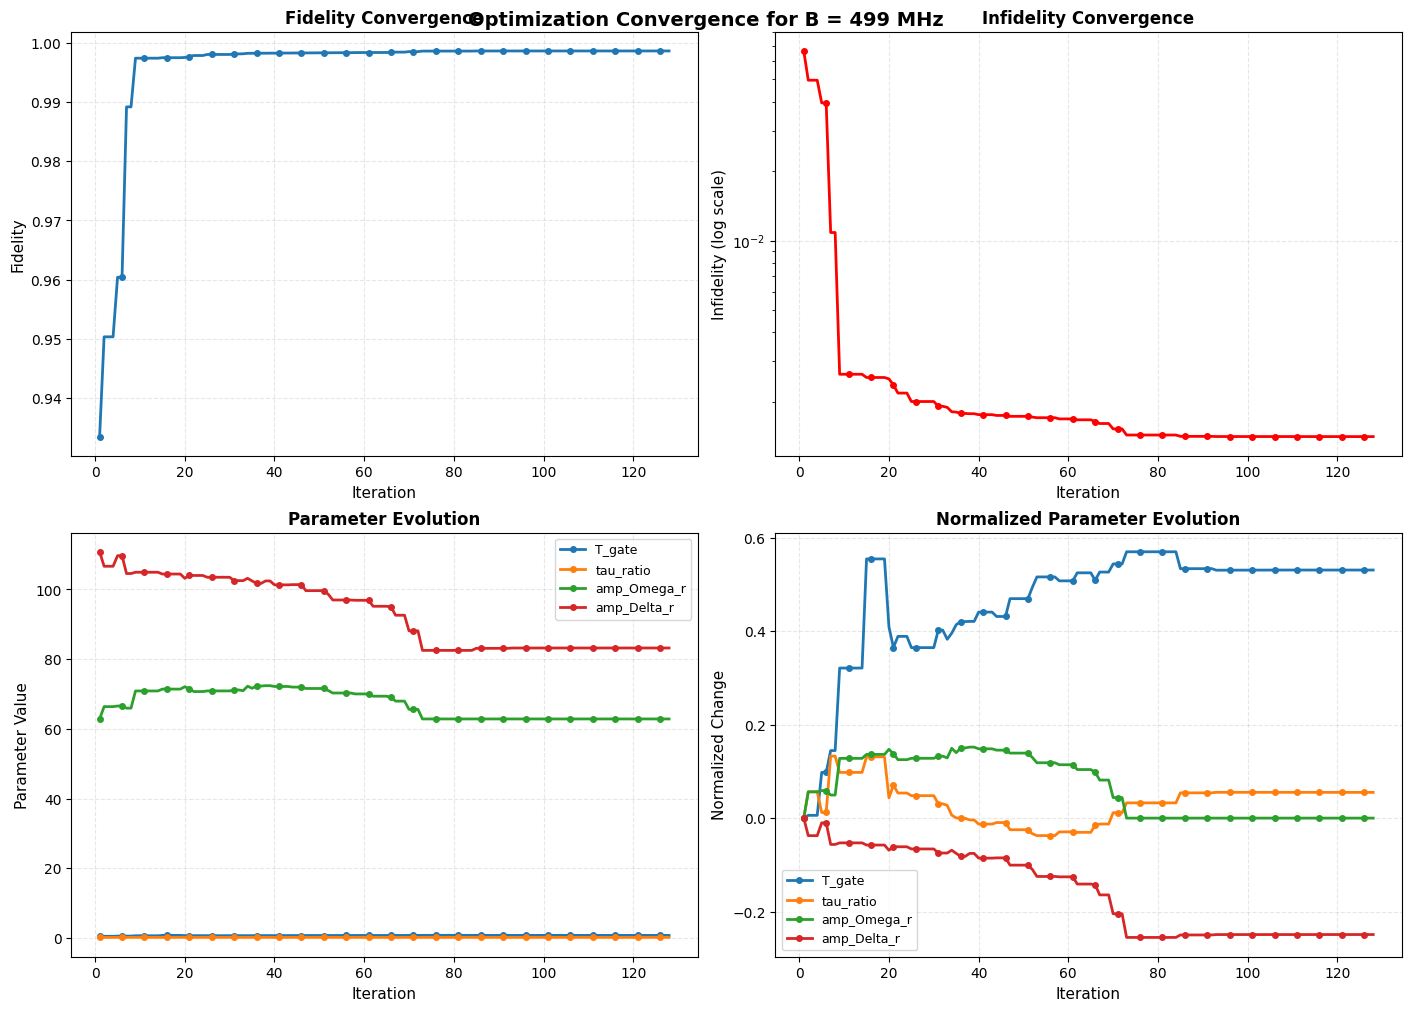

In [37]:
# Plot convergence using plotting_helpers function
fig, axes = plot_optimization_convergence(best_monitor.history, param_names, figsize=(14, 10))

# Add title with B value
fig.suptitle(f'Optimization Convergence for B = {B_to_analyze} MHz', 
             fontsize=14, fontweight='bold', y=0.995)

plt.show()